# LH2 FEEDING LINES PRELIMINARY DESIGN

*Author: F. Pollet - 2020*

## References
[1] Selecting the Optimum Pipe Size,  Randall W. Whitesides (PDH Center)

[2] The Potential of Liquid Hydrogen for long range aircraft propulsion, D. Verstraete

[3] A two-dimensional computational model of a PEMFC with liquid water transport, N.P. Siegel

[4] Safety standard for hydrogen and hydrogen systems, NASA

[5] Optimisation of the multilayer insulation - an engineering approach, M. Chorowski et al.


## Assumptions

* 100% Liquid hydrogen
* Single wall construction with either foam insulation or MLI insulation
* Fluid velocity @output = 2 m/s 
* Only the pipe wall and the insulation material are considered. All other layers (skin, open-cell foam to accommodate dimensional changes...) are not taken into account


## Equations

### Preliminary sizing of the inner diameter
The Adam's equation (in its approximated form) provides an estimation of the pipe diameter for flow rates lower than 100 gal/min:
$$ d = 0.80 \sqrt Q$$
where d is expressed in meters and Q in $m^3/s$. <br>
One may also derive the diameter from the flow rate and the fluid velocity:
$$ d = \frac{2}{\sqrt \pi} \sqrt \frac{Q}{V} $$
Based on NASA examples about hydrogen systems and the PEMFC model from N.P. Siegel, the fluid velocity is taken as $2 m/s$.

### Heat transfer model
We consider the following pipe with a foam insulation:

<div>
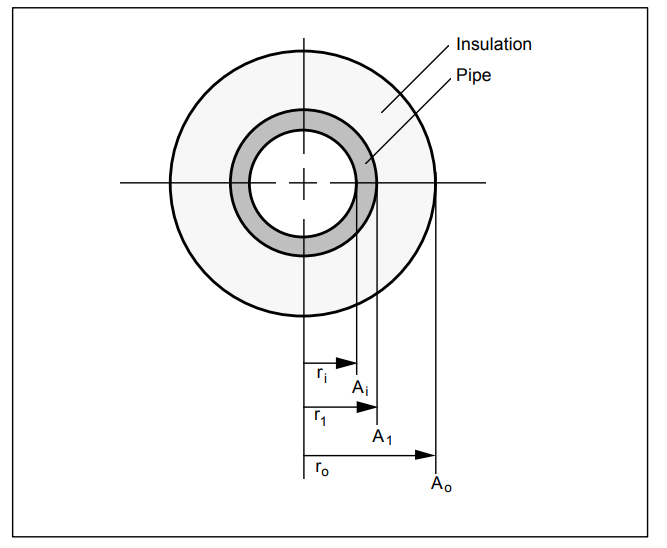
</div>

The liquid hydrogen flows through a steel pipe of length L at a temperature of 20.3K. The system is in steady state.

The following thermal transfers are considered:
-	internal convection between hydrogen and intern surface of the pipe wall
-	conduction through the pipe wall;
-	conduction through the insulation material;
-	external convection between air and the external surface of pipe insulation;

For each layer, the heat flux $Q$ is derived from the temperature variation and the thermal resistance of the material or the interface:
$$ Q = \frac{\Delta T}{R} $$

An iteration is made until the heat flux through each of the layers is equal.

The thermal resistances $R$ are defined as follows:

$$ R_{int} = \frac{1}{h_i A_i}$$
$$ R_{pipe} = \frac{ln(r_1/r_i)}{2 \pi L k_{pipe}}$$
$$ R_{ins} = \frac{ln(r_0/r_1)}{2 \pi L k_{ins}}$$
$$ R_{ext} = \frac{1}{h_0 A_0}$$

Note that a safety margin may be taken on the heat flux to take into consideration the losses through the pipe supports and the connections.

### Insulations
#### Rohacell foam and thermal conductivity variation
The rohacell foam was selected by D. Verstraete as a good insulation material for cryogenic tanks. The following data is extracted from its thesis:

$$ \rho_{rohacell} = 51.1 kg/m^3 $$

<div>
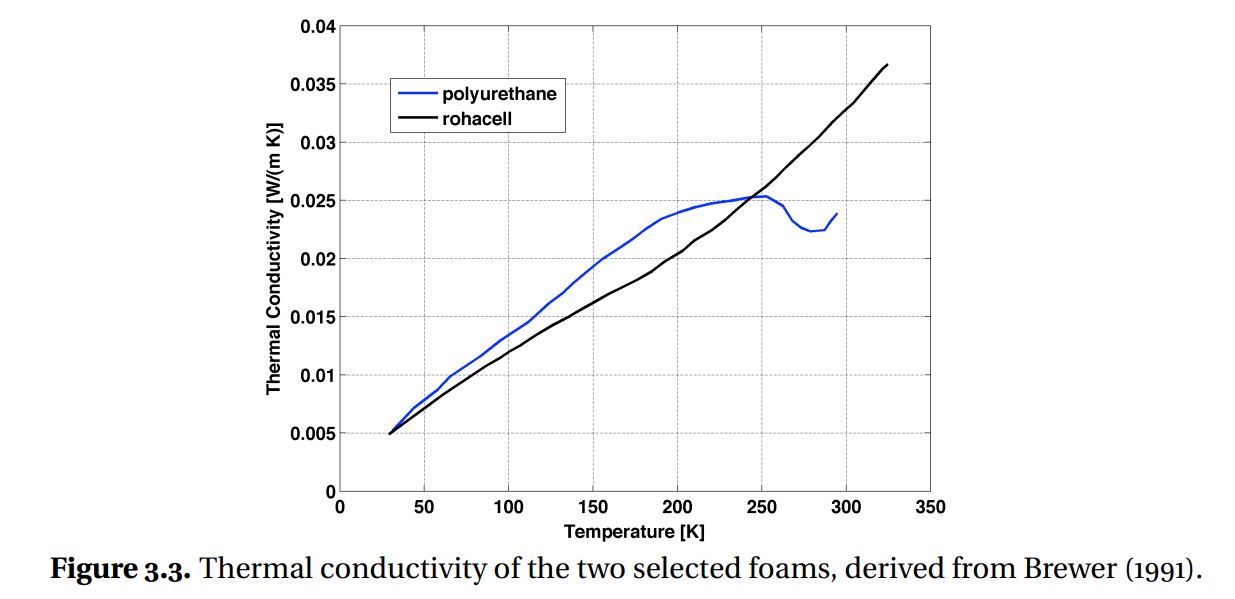
</div>

A linear model is chosen to describe the thermal conductivity of the rohacell foam:
$$ k ~[W/m.K] = 2.10^{-3} + 10^{-4} T~[K]$$

To take into account the variation of the thermal conductivity, the insulation layer is divided into a series of sub-layers of equal thickness. 

#### Multilayer insulation (MLI)
Multi layer insulations consist out of alternating layers of a lowemissivity metal foil and a thin insulating spacer. To minimize the heat transfer by residual gas conduction, the system has to operate at vacuum levels below 13 mPa. <br>
Based on "Optimisation of the multilayer insulation - an engineering approach, M. Chorowski et al.", we assume that the spacers conduction dominates over the radiative heat transfer and the residual gas conduction.

The effective spacer thermal conductivity is described by the following equation:

$$ k = 4.5 \sqrt {T/10} . 10^{-6} $$

A thickness of 5mm is adopted in this study, as  in the Cryoplane study (Allidieris & Janin, 2002).


## Input parameters

In [1]:
import numpy as np
from matplotlib import pyplot as plt

# H2 specifications
rho_LH2           = 70.78 # [kg/m3] (@ normal boiling point)
heat_vaporization = 445.6e3 #[J/kg]

# Flow parameters
mass_flow       = 0.025 # [kg/s]  (1500 kW FC system)
volumetric_flow = mass_flow/rho_LH2 # [m3/s]
fluid_velocity  = 2 # [m/s] (approximation, see references)

# Geometrical parameters
L = 10 # line length [m]
x = 4e-3 # pipe thickness, arbitrary [m]
y = 50e-3 # insulation thickness, arbitrary [m]

# Thermo parameters
T_amb = 298 # ambient temperature [K]
T_LH2 = 20.3 # LH2 temperature [K]
h_i = 55 # internal (LH2/pipe) heat transfer coefficient [W/m2.K]
h_0 = 5 # external (insulation/air) heat transfer coefficient [W/m2.K]
k_x = 16.3 # 304L steel thermal conductivity [W/m.K]

# Additional parameters for materials
rho_pipe = 7817 # 304L steel density [kg/m3]
rho_insulation = 51.1 # Rohacell foam density [kg/m3]
#rho_insulation = 24 # MLI density [kg/m3]


## Sizing and thermodynamics algorithms

In [2]:
def conductivity_law(T):
    # Thermal resistance of the insulation material [W/m.K]
    #k = 2e-3 + 1e-4 * T # rohacell foam
    k = 4.5*np.sqrt(T/10)*1e-6 # MLI
    return k


def thermo_model(T_amb, T_LH2, R_int, R_pipe, R_ext, r_1, r_0, L):
    # Returns the total heat flux 
    # by iterating over the heat flux through each layer until equality is reached
    
    # algorithm parameters
    n_iter = 10000 # max number of iterations
    count  = 0
    err    = 1
    n_mesh = 40 # number of sub-divisions of the insulation

    T_array = np.linspace(T_LH2, T_amb, n_mesh+4) # temperatures array

    radius_ins = np.linspace(r_1, r_0, n_mesh+1) # radius array of the insulation layers
    R_ins = np.array([np.log(radius_ins[i+1]/radius_ins[i]) / (2*np.pi*L) /
                            (conductivity_law((T_array[i+2]+T_array[i+3])/2))
                            for i in range(n_mesh)]) # init. of the thermal resistances of the insulation layers

    while count < n_iter and err > 1e-2:
        # LH2 - inner pipe convection
        T_array[1] = (T_array[2]*R_int + T_array[0]*R_pipe) / (R_pipe + R_int)
        Q_int = np.array([(T_array[1] - T_array[0]) / R_int])

        # pipe conduction
        T_array[2] = (T_array[3]*R_pipe + T_array[1]*R_ins[0]) / (R_ins[0] + R_pipe)
        Q_pipe = np.array([(T_array[2] - T_array[1]) / R_pipe])

        # insulation conduction
        for i in range(n_mesh): # for each layer
            k = conductivity_law((T_array[i+2] + T_array[i+3]) / 2)
            R_ins[i] = np.log(radius_ins[i+1]/radius_ins[i])/(2*np.pi*L)/k
            if i > 0:
                T_array[i+2] = (T_array[i+3]*R_ins[i-1] + T_array[i+1]*R_ins[i]) / (R_ins[i] + R_ins[i-1])
        Q_ins = np.array([(T_array[i+3] - T_array[i+2])/R_ins[i] for i in range(n_mesh)])

        # insulation - air convection
        T_array[n_mesh+2] = (T_array[n_mesh+3]*R_ins[n_mesh-1] + T_array[n_mesh+1]*R_ext) / (R_ins[n_mesh-1] + R_ext)
        Q_ext = np.array([(T_array[n_mesh+3] - T_array[n_mesh+2]) / R_ext])

        # Total heat flux
        Q = np.concatenate((Q_int,Q_pipe,Q_ins, Q_ext))

        err = np.linalg.norm(Q-np.mean(Q),2)
        count = count + 1
    
    #plt.plot(1000*np.concatenate((np.array([r_i]), radius_ins)), T_array[1:-1])
    #plt.xlabel('radius [mm]')
    #plt.ylabel('temperature (K)')
    #plt.show()
    
    return np.mean(Q), (R_int + R_pipe + np.sum(R_ins) + R_ext)


def pipe_sizing(volumetric_flow,fluid_velocity):
    # Returns an estimate of the pipe radius for given flow parameters (flow rate and velocity)
    r_i1 = 0.7994529*np.sqrt(volumetric_flow) / 2 # method 1 : Adam's equation (approximation)
    r_i2 = 1/np.sqrt(np.pi)*np.sqrt(volumetric_flow/fluid_velocity) # method 2 : using fluid velocity
    r_i  = (r_i1+r_i2)/2 # mean diameter
    return r_i

##############################################################################


# RADIUS [m]
r_i = pipe_sizing(volumetric_flow,fluid_velocity) # inner radius of the pipe
r_1 = r_i + x # outer radius of the pipe
r_0 = r_1 + y # outer radius of the insulation 

# AREAS [m2]
A_i = 2*np.pi*r_i*L
A_1 = 2*np.pi*r_1*L
A_0 = 2*np.pi*r_0*L

# THERMAL RESISTANCES [W/K]
R_int  = 1/(h_i*A_i) # internal convection
R_pipe = np.log(r_1/r_i)/(2*np.pi*L)/k_x # thermal resistance of the pipe
#R_ins  = np.log(r_0/r_1)/(2*np.pi*L)/k_y # thermal resistance of the insulation
R_ext  = 1/(h_0*A_0) # external convection

# HEAT FLUX[W]
#Q = (T_amb-T_LH2) / R_tot
Q, R_tot  = thermo_model(T_amb, T_LH2, R_int, R_pipe, R_ext, r_1, r_0, L) # heat flux and total resistance
Q = 1.3*Q # safety margin for supports and connections losses

# Heat leaks [-] and boil-off (BOG) [kg/h]
Q_leak = Q / (mass_flow*heat_vaporization)*100
BOG    = Q / heat_vaporization * 3600

# MASS [kg]
mass_pipe= rho_pipe * np.pi * L * (r_1**2 - r_i**2)
mass_ins = rho_insulation * np.pi * L * (r_0**2 - r_1**2)
mass_tot = mass_pipe + mass_ins 

# Results display
print("Inner radius of the pipe [mm]: ", r_i*1000)
print("Pipe wall thickness [mm]:      ", x*1000)
print("Insulation thickness [mm]:     ", y*1000)
print('----------------')
print("Mass pipe [kg]:                ", mass_pipe)
print("Mass insulation [kg]:          ", mass_ins)
print("Mass total [kg]:               ", mass_tot)
print('----------------')
print("Heat leak Q [W]:               ", Q)
print(" -     -    [%]:               ", Q_leak)
print("Boil-off GH2 [kg/h]:           ", BOG)


Inner radius of the pipe [mm]:  7.505012341066864
Pipe wall thickness [mm]:       4.0
Insulation thickness [mm]:      50.0
----------------
Mass pipe [kg]:                 18.67379800505946
Mass insulation [kg]:           5.860346195943912
Mass total [kg]:                24.53414420100337
----------------
Heat leak Q [W]:                0.23428551637586895
 -     -    [%]:                0.002103101583266328
Boil-off GH2 [kg/h]:            0.0018927914249396952


## Sensitivity study

The mass per unit length is estimated for various flow rates.

In [3]:
# H2 specifications
rho_LH2           = 70.78 # [kg/m3] (@ normal boiling point)
heat_vaporization = 445.6e3 #[J/kg]

# Flow parameters
mass_flow_array = np.arange(0.005,0.030,0.0025) # [kg/s]
fluid_velocity  = 2 # [m/s] (approximation, see references)

# Geometrical parameters
L = 1 # line length [m]
x = 4e-3 # pipe thickness, arbitrary [m]
y = 50e-3 # insulation thickness, arbitrary [m]

# Thermo parameters
T_amb = 298 # ambient temperature [K]
T_LH2 = 20.3 # LH2 temperature [K]
h_i = 55 # internal (LH2/pipe) heat transfer coefficient [W/m2.K]
h_0 = 5 # external (insulation/air) heat transfer coefficient [W/m2.K]
k_x = 16.3 # 304L steel thermal conductivity [W/m.K]

# Additional parameters for materials
rho_pipe = 7817 # 304L steel density [kg/m3]
#rho_insulation = 51.1 # Rohacell foam density [kg/m3]
rho_insulation = 24 # MLI density [kg/m3]
rho_insulation = 51.1 # Rohacell foam density [kg/m3]
mass_tot_array_Rohacell = []

for mass_flow in mass_flow_array:
    volumetric_flow = mass_flow/rho_LH2 # [m3/s]
    
    # RADIUS [m]
    r_i = pipe_sizing(volumetric_flow,fluid_velocity) # inner radius of the pipe
    r_1 = r_i + x # outer radius of the pipe
    r_0 = r_1 + y # outer radius of the insulation 

    # AREAS [m2]
    A_i = 2*np.pi*r_i*L
    A_1 = 2*np.pi*r_1*L
    A_0 = 2*np.pi*r_0*L

    # THERMAL RESISTANCES [W/K]
    R_int  = 1/(h_i*A_i) # internal convection
    R_pipe = np.log(r_1/r_i)/(2*np.pi*L)/k_x # thermal resistance of the pipe
    #R_ins  = np.log(r_0/r_1)/(2*np.pi*L)/k_y # thermal resistance of the insulation
    R_ext  = 1/(h_0*A_0) # external convection

    # HEAT FLUX[W]
    #Q = (T_amb-T_LH2) / R_tot
    Q, R_tot  = thermo_model(T_amb, T_LH2, R_int, R_pipe, R_ext, r_1, r_0, L) # heat flux and total resistance
    Q = 1.3*Q # safety margin for supports and connections losses

    # Heat leaks [-] and boil-off (BOG) [kg/h]
    Q_leak = Q / (mass_flow*heat_vaporization)*100
    BOG    = Q / heat_vaporization * 3600

    # MASS [kg]
    mass_pipe= rho_pipe * np.pi * L * (r_1**2 - r_i**2)
    mass_ins = rho_insulation * np.pi * L * (r_0**2 - r_1**2)
    mass_tot = mass_pipe + mass_ins 
    
    mass_tot_array_Rohacell.append(mass_tot)

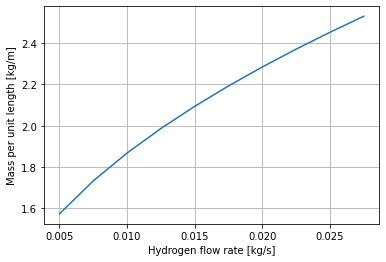

In [6]:
plt.plot(mass_flow_array,mass_tot_array_Rohacell,label='Rohacell foam')
#plt.plot(mass_flow_array,mass_tot_array_MLI, label='Multi-Layer Insulation')
#plt.title('Liquid hydrogen pipes design')
plt.xlabel('Hydrogen flow rate [kg/s]')
plt.ylabel('Mass per unit length [kg/m]')
#plt.legend()
plt.grid()

In [5]:

mass_tot_array_MLI

NameError: name 'mass_tot_array_MLI' is not defined